# Feature Design and Exploratory Data Analysis

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Data/Gold/main.csv')

# Feature Design

## Expected Player Performance

Our goal is to calculate the expected performance score (stint_score) for a player based on a regression model that finds the relationship between stint_score and the player's percent_through_career.

We begin with a visual analysis of these variables

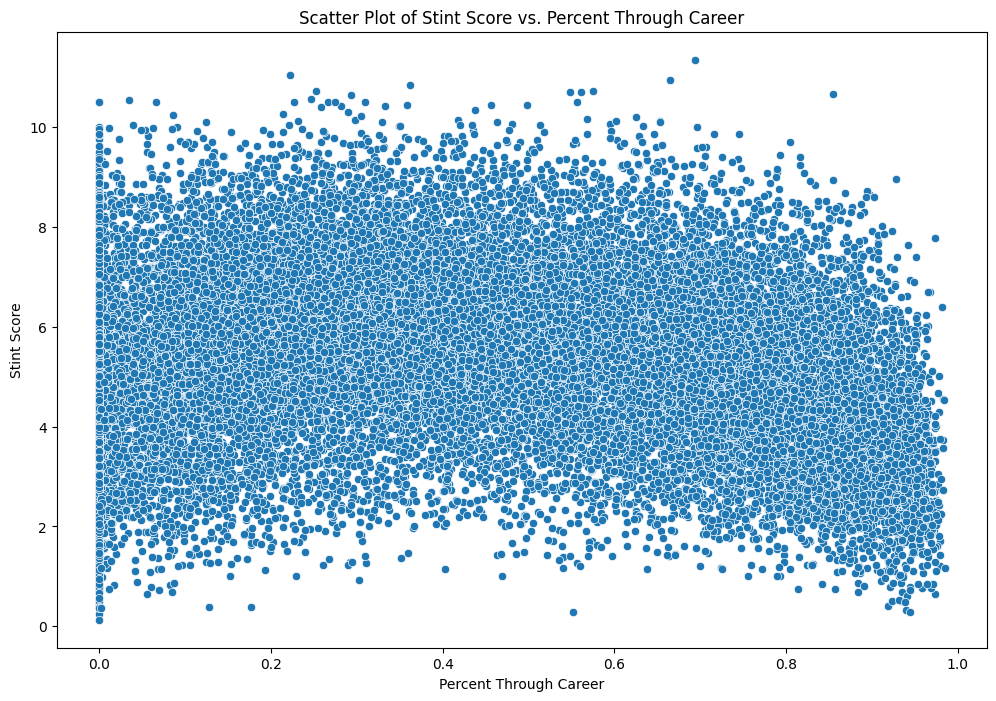

In [235]:
# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='percent_through_career', y='stint_score')

# Add titles and labels
plt.title('Scatter Plot of Stint Score vs. Percent Through Career')
plt.xlabel('Percent Through Career')
plt.ylabel('Stint Score')

# Show the plot
plt.show()

There is a wide spread of potential stint scores depending how far the player is through their career.  Stint scores generally seem to improve until around 50% through a player's career, and they fall off after that.

Polynomial regression can be used to model the relationship between these two variables and create a best-fit-curve.

In [236]:
import numpy as np
import statsmodels.api as sm

# Define the independent variable (X) and the dependent variable (y)
X = df['percent_through_career']
y = df['stint_score']

# Generate polynomial features (e.g., quadratic)
X_poly = np.column_stack((X, X**2, X**3))  # Adjust degree as needed

# Add a constant to the polynomial features
X_poly = sm.add_constant(X_poly)

# Fit the polynomial regression model
model = sm.OLS(y, X_poly).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            stint_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     1409.
Date:                Sun, 21 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:14:23   Log-Likelihood:                -47684.
No. Observations:               24959   AIC:                         9.538e+04
Df Residuals:                   24955   BIC:                         9.541e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9613      0.029    171.938      0.0

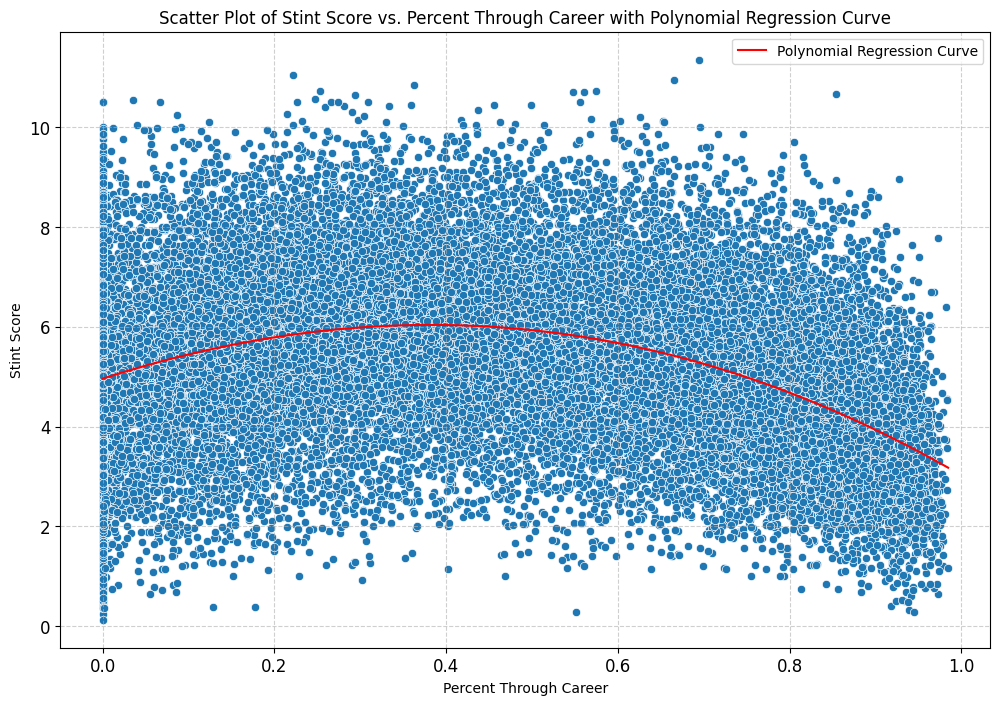

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with a polynomial regression curve
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='percent_through_career', y='stint_score')

# Generate predictions for the polynomial regression curve
X_pred = np.linspace(df['percent_through_career'].min(), df['percent_through_career'].max(), 100)
X_pred_poly = np.column_stack((X_pred, X_pred**2, X_pred**3))  # Adjust degree as needed
X_pred_poly = sm.add_constant(X_pred_poly)
y_pred = model.predict(X_pred_poly)

# Plot the polynomial regression curve
plt.plot(X_pred, y_pred, color='red', label='Polynomial Regression Curve')

# Add titles and labels
plt.title('Scatter Plot of Stint Score vs. Percent Through Career with Polynomial Regression Curve')
plt.xlabel('Percent Through Career')
plt.ylabel('Stint Score')
plt.legend()

# Enhance the plot aesthetics
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


With the polynomial regression model built, we can use it to make predictions and add them to our dataframe based on the player's percent_through_career. From there we can determine how accurate the expected performance turns out to be.

In [238]:
# Generate polynomial features for the 'percent_through_career' column for prediction
df_poly = np.column_stack((df['percent_through_career'], df['percent_through_career']**2, df['percent_through_career']**3))  # Adjust degree as needed
df_poly = sm.add_constant(df_poly)

# Make predictions using the fitted model
df['expected_performance'] = model.predict(df_poly)

# Display the updated dataframe with the new 'expected_performance' column
print(df[['playerID', 'percent_through_career', 'stint_score', 'expected_performance']])

        playerID  percent_through_career  stint_score  expected_performance
0      abdelju01                0.019139     2.345497              5.065080
1      abdelju01                0.258373     9.699647              5.923270
2      abdelju01                0.612440     7.016692              5.632218
3       abelcl01                0.000000     7.999975              4.961308
4       abelcl01                0.132132     4.918262              5.572730
...          ...                     ...          ...                   ...
24954  zyuzian01                0.457661     5.631681              5.995977
24955  zyuzian01                0.590726     6.973762              5.705924
24956  zyuzian01                0.721774     6.322831              5.146622
24957  zyuzian01                0.836694     1.550582              4.426902
24958  zyuzian01                0.935484     3.248834              3.633040

[24959 rows x 4 columns]


From here, we will show how the player's actual performance (stint score) compares to their expected performance. We will use a score system to evaluate the player's performance:
<li>5 - Actual performance is greater than one standard deviation (of expected performance) above expected performance.</li>
<li>4 - Actual performance is within the top 33% of values that fall within the expected performance</li>
<li>3 - Actual performance is within the middle 33% of values that fall within the expected performance</li>
<li>2 - Actual performance is within the bottom 33% of values that fall within the expected performance</li>
<li>1 - Actual performance is lower than on standard deviation below expected peformance</li>

In [239]:
# Calculate residuals and their standard deviation
df['residuals'] = df['stint_score'] - df['expected_performance']
std_residuals = df['residuals'].std()

# Calculate tertile boundaries within the standard deviation range
lower_bound = -std_residuals
upper_bound = std_residuals
tertile_1_upper = lower_bound + (upper_bound - lower_bound) / 3
tertile_2_upper = lower_bound + 2 * (upper_bound - lower_bound) / 3

# Define the conditions for the new column
conditions = [
    (df['stint_score'] > df['expected_performance'] + std_residuals),  # Exceeding
    (df['stint_score'] <= df['expected_performance'] - std_residuals),  # Not Meeting
    ((df['stint_score'] > df['expected_performance'] - std_residuals) & 
     (df['stint_score'] <= df['expected_performance'] - std_residuals + (upper_bound - lower_bound) / 3)),  # Lower Tertile
    ((df['stint_score'] > df['expected_performance'] - std_residuals + (upper_bound - lower_bound) / 3) & 
     (df['stint_score'] <= df['expected_performance'] - std_residuals + 2 * (upper_bound - lower_bound) / 3)),  # Middle Tertile
    ((df['stint_score'] > df['expected_performance'] - std_residuals + 2 * (upper_bound - lower_bound) / 3) & 
     (df['stint_score'] <= df['expected_performance'] + std_residuals))  # Upper Tertile
]

# Define the corresponding categories
choices = [5, 1, 2, 3, 4]

# Create the new column with the conditions
df['performance_evaluation'] = np.select(conditions, choices, default=3)

# Drop the residuals column if not needed
df.drop(columns=['residuals'], inplace=True)

# Display the updated dataframe with the new 'performance_evaluation' column
print(df[['playerID', 'percent_through_career', 'stint_score', 'expected_performance', 'performance_evaluation']])


        playerID  percent_through_career  stint_score  expected_performance  \
0      abdelju01                0.019139     2.345497              5.065080   
1      abdelju01                0.258373     9.699647              5.923270   
2      abdelju01                0.612440     7.016692              5.632218   
3       abelcl01                0.000000     7.999975              4.961308   
4       abelcl01                0.132132     4.918262              5.572730   
...          ...                     ...          ...                   ...   
24954  zyuzian01                0.457661     5.631681              5.995977   
24955  zyuzian01                0.590726     6.973762              5.705924   
24956  zyuzian01                0.721774     6.322831              5.146622   
24957  zyuzian01                0.836694     1.550582              4.426902   
24958  zyuzian01                0.935484     3.248834              3.633040   

       performance_evaluation  
0                  

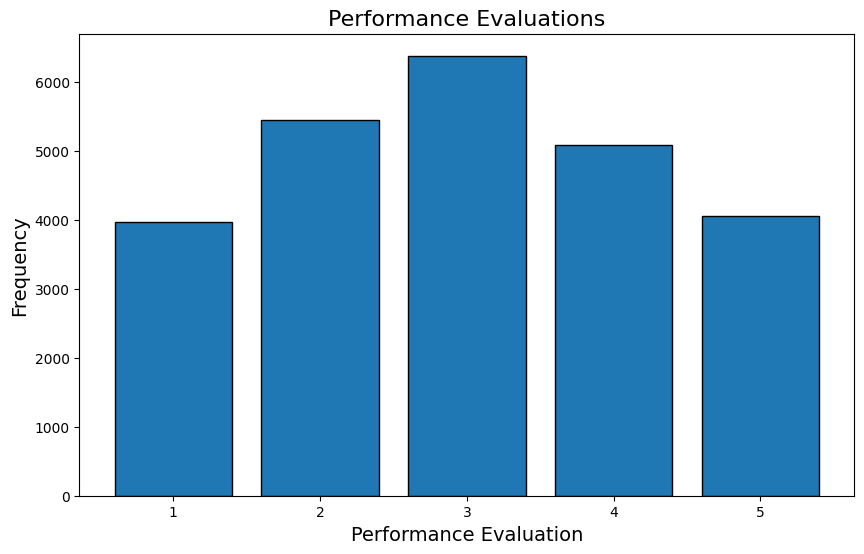

In [240]:
plt.figure(figsize=(10, 6))
# Use 'bar' type and adjust width for spacing
n, bins, patches = plt.hist(df['performance_evaluation'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', rwidth=0.8)
plt.title('Performance Evaluations', fontsize=16)
plt.xlabel('Performance Evaluation', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks([1, 2, 3, 4, 5])

# Show the plot
plt.show()

# Initial - Exploratory Data Analysis


## Data Dimension

In [241]:
df.shape

(24959, 58)

## Dataframe contents

In [242]:
df.head()

,playerID,year,stint,tmID,pos,GP,G,A,Pts,PIM,...,SOG_per_game_score,award_count_per_game_score,+/-_score,stint_score,stint_vs_prev_stint,teammates_same_nationality,tsm_vs_prev_stint,age,expected_performance,performance_evaluation
0,abdelju01,2009,1,DET,L,50.0,3.0,3.0,6.0,35.0,...,0.345497,0.5,0.000000,2.345497,NaN,3,NaN,22.0,5.065080,1
1,abdelju01,2010,1,DET,L,74.0,7.0,12.0,19.0,61.0,...,0.999996,0.5,1.000000,9.699647,better,3,no change,23.0,5.923270,5
2,abdelju01,2011,1,DET,L,81.0,8.0,14.0,22.0,62.0,...,0.000000,0.5,0.576923,7.016692,worse,1,fewer,24.0,5.632218,4
3,abelcl01,1926,1,NYR,D,44.0,8.0,4.0,12.0,78.0,...,0.500000,0.5,0.500000,7.999975,NaN,0,NaN,26.0,4.961308,5
4,abelcl01,1927,1,NYR,D,23.0,0.0,1.0,1.0,28.0,...,0.500000,0.5,0.500000,4.918262,worse,0,no change,27.0,5.572730,2


## Check for missing values

In [243]:
df.isnull().sum()

playerID                         0
year                             0
stint                            0
tmID                             0
pos                              0
GP                               0
G                                0
A                                0
Pts                              0
PIM                              0
+/-                              0
PPG                              0
PPA                              0
SHG                              0
SHA                              0
GWG                              0
SOG                              0
stint_index                      0
career_games                     0
total_GP_prior_to_stint          0
percent_through_career           0
award_count                      0
firstName                        0
lastName                         0
height                           0
weight                           0
birthYear                        0
birthCountry                     0
G_per_game          

## Overview of data types of each column in the dataframe

In [244]:
df.dtypes


playerID                       object
year                            int64
stint                           int64
tmID                           object
pos                            object
GP                            float64
G                             float64
A                             float64
Pts                           float64
PIM                           float64
+/-                           float64
PPG                           float64
PPA                           float64
SHG                           float64
SHA                           float64
GWG                           float64
SOG                           float64
stint_index                     int64
career_games                  float64
total_GP_prior_to_stint       float64
percent_through_career        float64
award_count                   float64
firstName                      object
lastName                       object
height                        float64
weight                        float64
birthYear   

In [245]:
df.select_dtypes(include='number')

,year,stint,GP,G,A,Pts,PIM,+/-,PPG,PPA,...,SHA_per_game_score,GWG_per_game_score,SOG_per_game_score,award_count_per_game_score,+/-_score,stint_score,teammates_same_nationality,age,expected_performance,performance_evaluation
0,2009,1,50.0,3.0,3.0,6.0,35.0,-11.0,0.0,0.0,...,0.000000,0.000000,0.345497,0.5,0.000000,2.345497,3,22.0,5.065080,1
1,2010,1,74.0,7.0,12.0,19.0,61.0,15.0,0.0,0.0,...,0.999926,0.999926,0.999996,0.5,1.000000,9.699647,3,23.0,5.923270,5
2,2011,1,81.0,8.0,14.0,22.0,62.0,4.0,0.0,0.0,...,0.000000,0.913513,0.000000,0.5,0.576923,7.016692,1,24.0,5.632218,4
3,1926,1,44.0,8.0,4.0,12.0,78.0,0.0,0.0,0.0,...,0.500000,0.500000,0.500000,0.5,0.500000,7.999975,0,26.0,4.961308,5
4,1927,1,23.0,0.0,1.0,1.0,28.0,0.0,0.0,0.0,...,0.500000,0.500000,0.500000,0.5,0.500000,4.918262,0,27.0,5.572730,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24954,2002,2,66.0,4.0,12.0,16.0,34.0,-7.0,2.0,5.0,...,0.999978,0.000000,0.953302,0.5,0.250000,5.631681,0,24.0,5.995977,3
24955,2003,1,65.0,8.0,13.0,21.0,48.0,4.0,4.0,4.0,...,0.000000,0.430757,0.843948,0.5,0.800000,6.973762,0,25.0,5.705924,4
24956,2005,1,57.0,7.0,11.0,18.0,50.0,-12.0,4.0,4.0,...,0.000000,0.491214,0.652307,0.5,0.000000,6.322831,0,27.0,5.146622,4
24957,2006,1,49.0,1.0,5.0,6.0,30.0,-2.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.5,0.500000,1.550582,0,28.0,4.426902,1


In [246]:
df.select_dtypes(include='object')

,playerID,tmID,pos,firstName,lastName,birthCountry,stint_vs_prev_stint,tsm_vs_prev_stint
0,abdelju01,DET,L,Justin,Abdelkader,USA,NaN,NaN
1,abdelju01,DET,L,Justin,Abdelkader,USA,better,no change
2,abdelju01,DET,L,Justin,Abdelkader,USA,worse,fewer
3,abelcl01,NYR,D,Clarence,Abel,USA,NaN,NaN
4,abelcl01,NYR,D,Clarence,Abel,USA,worse,no change
...,...,...,...,...,...,...,...,...
24954,zyuzian01,MIN,D,Andrei,Zyuzin,Russia,better,fewer
24955,zyuzian01,MIN,D,Andrei,Zyuzin,Russia,better,no change
24956,zyuzian01,MIN,D,Andrei,Zyuzin,Russia,worse,no change
24957,zyuzian01,CAL,D,Andrei,Zyuzin,Russia,worse,no change


## Data Distributions

<Figure size 1200x800 with 0 Axes>

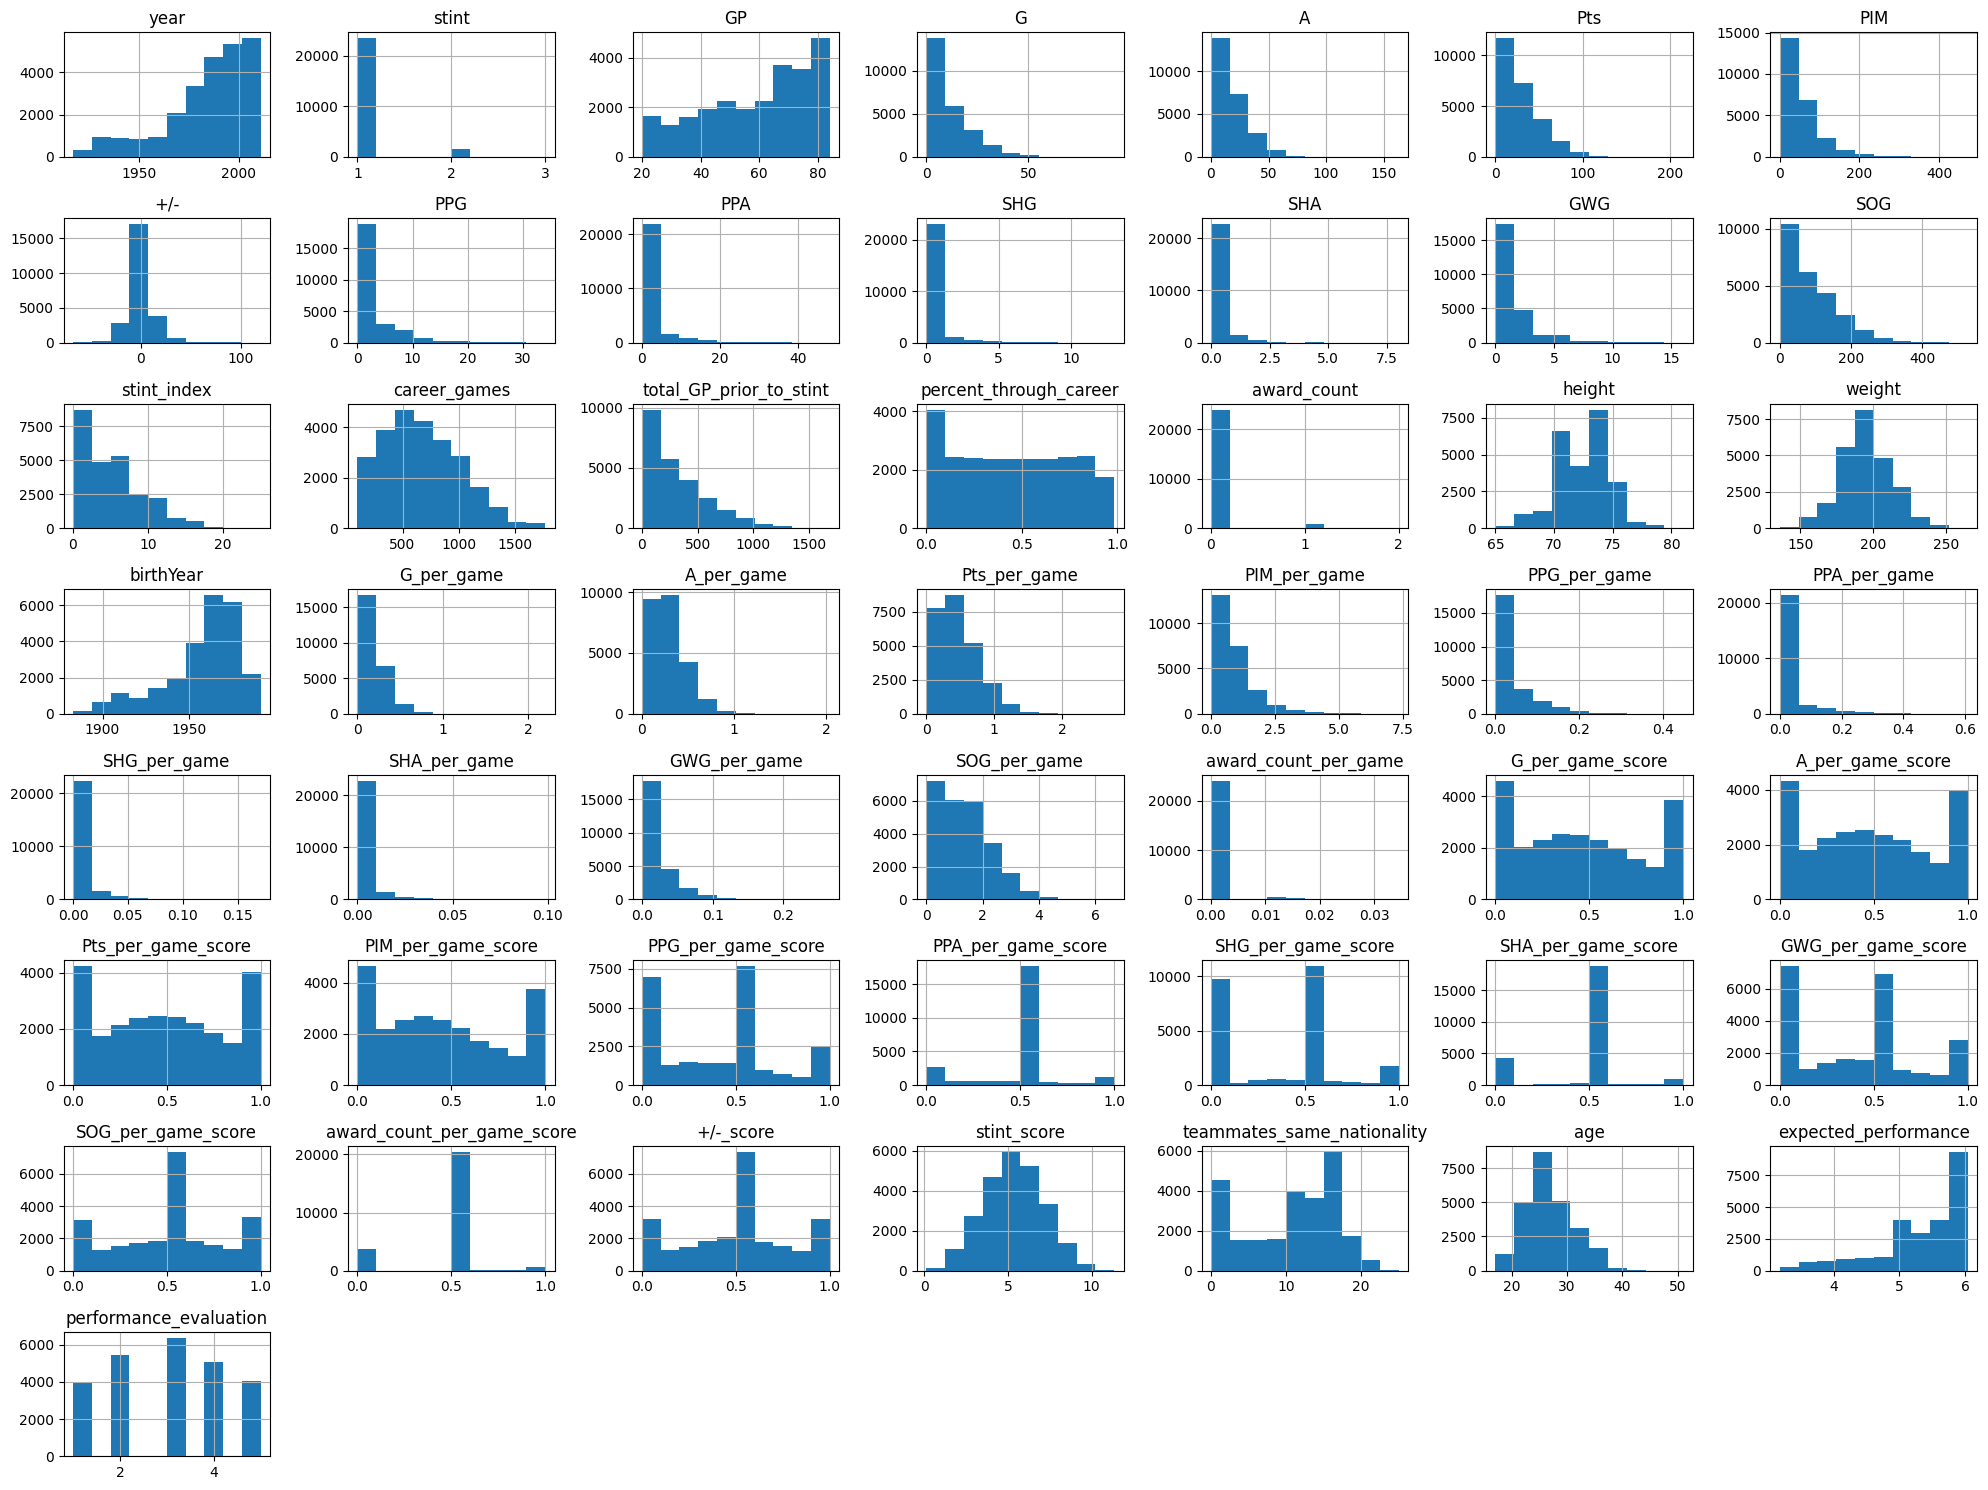

In [247]:
# Data Distribution
plt.figure(figsize=(12, 8))
df.hist(figsize=(20, 15))
plt.tight_layout()
plt.show()

## Data Correlations

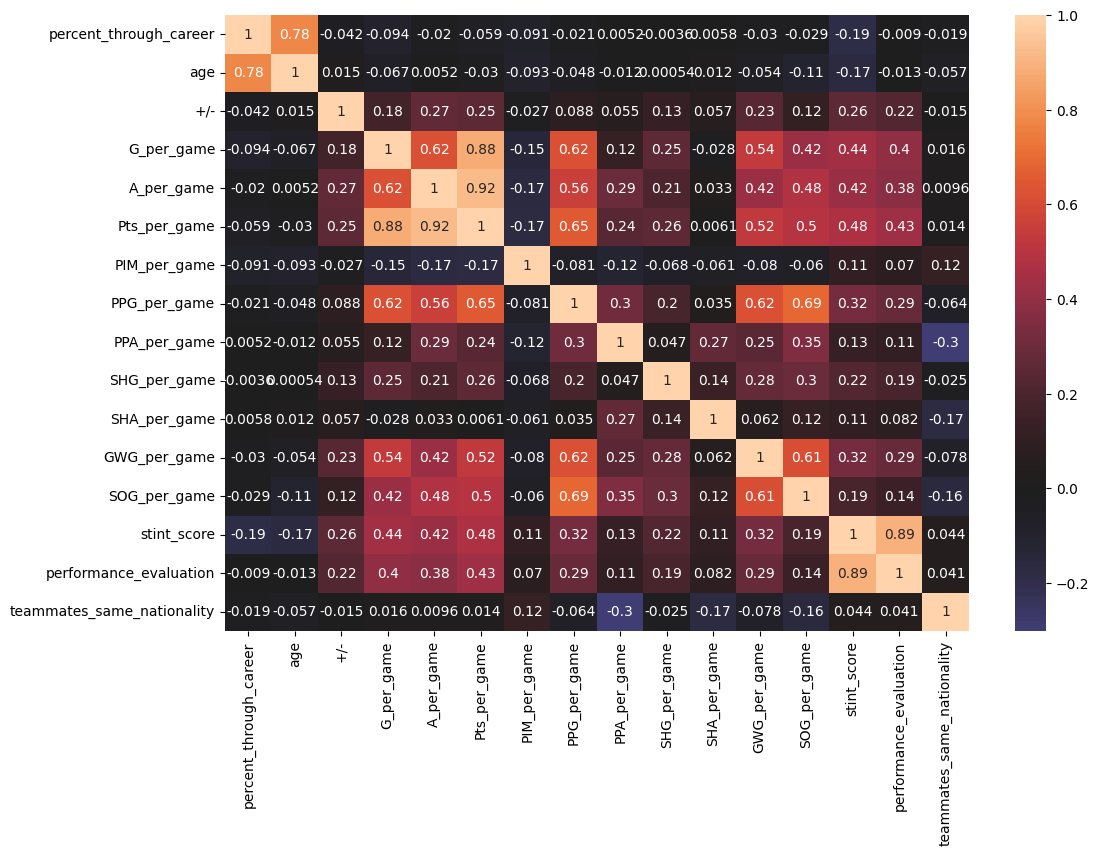

In [253]:
# Relationships Between Variables

# list variables
numerical_variables = [
    'percent_through_career',
    'age',
    '+/-',
    'G_per_game',
    'A_per_game',
    'Pts_per_game',
    'PIM_per_game',
    'PPG_per_game',
    'PPA_per_game',
    'SHG_per_game',
    'SHA_per_game',
    'GWG_per_game',
    'SOG_per_game',
    'stint_score',
    'performance_evaluation',
    'teammates_same_nationality'
]

plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_variables].corr()
sns.heatmap(correlation_matrix, annot=True, center=0)
plt.show()

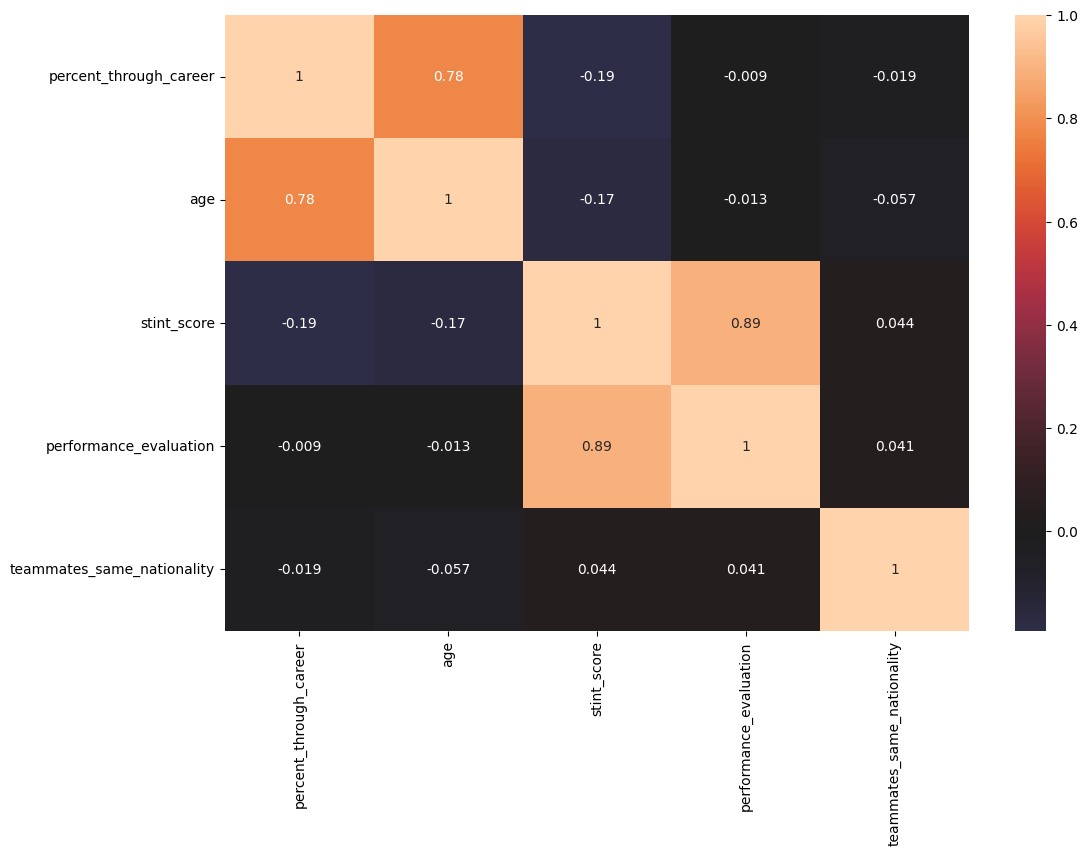

In [257]:
# list focused variables
numerical_variables = [
    'percent_through_career',
    'age',
    # '+/-',
    # 'G_per_game',
    # 'A_per_game',
    # 'Pts_per_game',
    # 'PIM_per_game',
    # 'PPG_per_game',
    # 'PPA_per_game',
    # 'SHG_per_game',
    # 'SHA_per_game',
    # 'GWG_per_game',
    # 'SOG_per_game',
    'stint_score',
    'performance_evaluation',
    'teammates_same_nationality'
]


plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_variables].corr()
sns.heatmap(correlation_matrix, annot=True, center=0)
plt.show()

## Countries
We are going to narrow our scope and look at specific birth countries, prioritizing those with the highest average number of teammates.

In [ ]:
# Group by 'birthCountry' and calculate the average number of 'teammates_same_nationality'
avg_teammates_same_nationality = df.groupby('birthCountry')['teammates_same_nationality'].mean()

# Convert to a DataFrame and sort by the average number of 'teammates_same_nationality'
avg_teammates_same_nationality = avg_teammates_same_nationality.reset_index().sort_values(by='teammates_same_nationality', ascending=False)

# Display the result
print(avg_teammates_same_nationality)

         birthCountry  teammates_same_nationality
4              Canada                   13.724428
29                USA                    3.372253
26             Sweden                    1.345733
5      Czech Republic                    1.292857
20             Russia                    1.228277
8             Finland                    0.712154
22           Slovakia                    0.583333
1             Belarus                    0.250000
21           Scotland                    0.227273
10            Germany                    0.206349
31            Ukraine                    0.189474
7             England                    0.037736
0             Austria                    0.000000
11            Ireland                    0.000000
9              France                    0.000000
2              Brazil                    0.000000
6             Denmark                    0.000000
3   Brunei Darussalam                    0.000000
17             Norway                    0.000000


There is a significant drop off in average teammates after Slovakia who has the 7th highest average number of teammates.  At this point, the top 7 countries here look like they may have enough data for us to make observations.

Now we will look at total unique players per country:

In [ ]:
# Group by 'birthCountry' and count unique 'playerID's
unique_players_per_country = df.groupby('birthCountry')['playerID'].nunique()

# Convert to a DataFrame and sort by the count of unique 'playerID's
unique_players_per_country = unique_players_per_country.reset_index().sort_values(by='playerID', ascending=False)

# Rename the columns for clarity
unique_players_per_country.columns = ['birthCountry', 'unique_playerIDs']

# Display the result
print(unique_players_per_country)

         birthCountry  unique_playerIDs
4              Canada              2070
29                USA               378
26             Sweden               118
5      Czech Republic                99
20             Russia                77
8             Finland                60
22           Slovakia                31
10            Germany                14
31            Ukraine                 9
30               USSR                 6
7             England                 5
21           Scotland                 5
19             Poland                 5
6             Denmark                 4
14             Latvia                 4
0             Austria                 3
1             Belarus                 3
15          Lithuania                 2
32          Venezuela                 2
27        Switzerland                 2
11            Ireland                 2
12              Italy                 1
2              Brazil                 1
3   Brunei Darussalam                 1


Once more, there is a significant drop after the 7th country, Slovakia. 

# Exploratory Analysis by Country

To view Exploratory Analysis by Country, view the following notebooks
Canada 
USA
Sweden
Czech Republic
Russia
Finland
Slovakia